In [2]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import random
import scipy.integrate as integrate
import scipy.stats as stats
import torch
import time
import pandas as pd
from brian2 import *
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import sbi



INFO       Cache size for target 'cython': 5681116866 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/awilson/.cython/brian_extensions' directory. [brian2]


In [162]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)

Current Working Directory: /home/awilson/Documents/PhD_Project/tadpoleAdEx


In [47]:
# let's try with aIN first since dIN params are a bit uncertain
def run_sim(sbi_params):
    
    start_scope()
    
    N_D = 1
    
    # sbi params
     # try fixing cm = 4pF, resting potential/E_L = -51mV, Ap threshold -28mV, g_l = 3.68 from Sauotis et al., 2007 
    din_cm = 4 * pF
    din_g_L = 3.68 * nS 
    din_E_L = -51 * mV 
    din_V_T = -28 * mV 
    din_slope_f = float(sbi_params[0]) * mV 
    din_a = float(sbi_params[1]) * nS 
    din_tau_w = float(sbi_params[2]) * ms 
    din_b = float(sbi_params[3]) * pA 
    din_V_reset = float(sbi_params[4]) * mV
    din_i_stim = 200 #float(sbi_params[5]) 
    
    # Define the time points and corresponding values
    values = [0, din_i_stim] * pA

    # Create the TimedArray
    timed_array = TimedArray(values, dt=0.08*second)

    E_ex = 0 * mV
    E_in = -70 * mV

    v_spike_threshold = 0 * mV
    simulation_time = 1*second

    parameters = {'general': {'tau_exc':5*ms, 'tau_inh':5*ms, 'E_exc':E_ex, 'E_inh':E_in, 'v_sp':v_spike_threshold},
                'dins': {'N': N_D, 'b':din_b, 'a':din_a, 'tau_w':din_tau_w, 'slope_f':din_slope_f, 'vr':din_V_reset, 'c_m':din_cm, 'e_l':din_E_L, \
                        'v_t': din_V_T, 'g_l': din_g_L, 'v_initial':din_E_L, 'i_stim':timed_array} \
                }



    eqs = """
    dv/dt = (g_l*(e_l-v) + g_l*slope_f*exp((v-v_t)/slope_f) - g_exc*(v-E_exc) - g_inh*(v-E_inh) + i_stim(t) - w)/c_m : volt
    dw/dt = (a*(v - e_l) - w)/tau_w : amp
    dg_exc/dt = -g_exc/tau_exc : siemens 
    dg_inh/dt = -g_inh/tau_inh : siemens
    """

    din_params = parameters['general'].copy()
    din_params.update(parameters['dins'])

    # Define neuron groups
    din = NeuronGroup(N_D, model=eqs, method='euler', threshold='v > 0*mV', reset='v = vr\nw = w + b', namespace=din_params)

    din.v = parameters['dins']['e_l']

    din.w = 0

    mon_din = StateMonitor(din, ['v', 'g_exc', 'g_inh', 'w'], record=0)  # Record the membrane potential of the first dIN
    din_spike_mon = SpikeMonitor(din)
    defaultclock.dt = 0.1 * ms
    time_secs = simulation_time
    run(time_secs)

#     fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 16), sharex=True)
#     ax[0].plot(mon_din.t / ms, mon_din.v[0]/mV, label='din voltage', color='blue')
#     ax[0].set(ylabel='Voltage (mV)')
#     ax[1].plot(mon_din.t / ms, mon_din.g_exc[0]/nsiemens, label='din g exc', color='blue')
#     ax[1].set(ylabel='g exc (nsiemens)')
#     ax[2].plot(mon_din.t / ms, mon_din.g_inh[0]/mV, label='din g inh', color='blue')
#     ax[2].set(ylabel='g inh (nsiemens)')
#     ax[3].plot(mon_din.t / ms, mon_din.w[0]/pA, label='din w', color='blue')
#     ax[3].set(xlabel='Time (ms)', ylabel='w (nA)')


#     ax[0].legend()
#     ax[1].legend()
#     ax[2].legend()
#     ax[3].legend()
    
    return mon_din.v / mV, din_spike_mon.t / ms

In [48]:
import scipy.stats as stats

def calculate_summary_statistics_brian(x, spikes, delta_t):
    V_thr = 0
    V_trace = np.array(x)
    if len(spikes) > 0:
        spike_num = len(spikes)
    else:
        spike_times = []
        spike_num = 0
        latency_spike1 = 100000
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    if spike_num == 1:
        latency_spike1 = spikes[0]
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    elif spike_num > 1:
        latency_spike1 = spikes[0]
        latency_spikes1_2 = spikes[1] - spikes[0]
        latency_spikes_last2 = spikes[-1] - spikes[-2]
    mean_V = np.mean(V_trace)
    std_V = np.std(V_trace)
    skew_V = stats.skew(V_trace)
    kurtosis_V = stats.kurtosis(V_trace)
#     V_pre_spike1_sampled = V_pre_spike_1[0::(1/delta_t)]
    min_V = np.min(V_trace)
    sum_stats = np.array((spike_num, latency_spike1, latency_spikes1_2, latency_spikes_last2, \
                           min_V, mean_V, std_V, skew_V, kurtosis_V))
#     sum_stats = np.array((spike_num, latency_spike1, latency_spikes1_2, latency_spikes_last2, \
#                                min_V_pre_spike1, V_resting_mn, V_resting_std, mean_V, std_V, skew_V, kurtosis_V))
#     sum_stats = np.array((spike_num, mean_V, std_V, skew_V, kurtosis_V))
    return sum_stats

def calculate_summary_statistics(x,delta_t):
    V_thr = -5
    V_trace = np.array(x)
#     V_resting = V_trace[:int(t_on/delta_t)]
#     V_resting_mn = np.mean(V_resting)
#     V_resting_std = np.std(V_resting)
    spike_ind_int = np.where(V_trace >= V_thr)[0]
    if len(spike_ind_int) > 0:
        spike_ind = [spike_ind_int[0]]
        for i in range(len(spike_ind_int)-1):
            if spike_ind_int[i+1] - spike_ind_int[i] != 1:
                spike_ind.append(spike_ind_int[i+1])
        spike_times =  [i*delta_t for i in spike_ind]
        spike_num = len(spike_times)
    else:
        spike_times = []
        spike_num = 0
        latency_spike1 = 100000
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    if spike_num == 1:
        latency_spike1 = spike_times[0]
        latency_spikes1_2 = 100000
        latency_spikes_last2 = 100000
    elif spike_num > 1:
        latency_spike1 = spike_times[0]
        latency_spikes1_2 = spike_times[1] - spike_times[0]
        latency_spikes_last2 = spike_times[-1] - spike_times[-2]
    mean_V = np.mean(V_trace)
    std_V = np.std(V_trace)
    skew_V = stats.skew(V_trace)
    kurtosis_V = stats.kurtosis(V_trace)
#     V_pre_spike1_sampled = V_pre_spike_1[0::(1/delta_t)]
    min_V = np.min(V_trace)
    sum_stats = np.array((spike_num, latency_spike1, latency_spikes1_2, latency_spikes_last2, \
                           min_V, mean_V, std_V, skew_V, kurtosis_V))
#   sum_stats = np.array((spike_num, latency_spike1))

    return sum_stats
    

In [49]:

def simulation_wrapper(params):
    delta_t = 0.1 * ms
    obs_v, obs_spikes = run_sim(params)
    summstats = torch.from_numpy(calculate_summary_statistics(obs_v[0],delta_t))
    return summstats

In [50]:
# Generate prior distribution on parameters
# Parameters to find: Cm, gL, EL, VT, slope_f, a, tau_w, b, V_r, I

# including current as parameter
prior_min = [0, -10, 0, 0, -70]
prior_max = [50, 20, 100, 200, -20]
prior =sbi.utils.torchutils.BoxUniform(
        low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

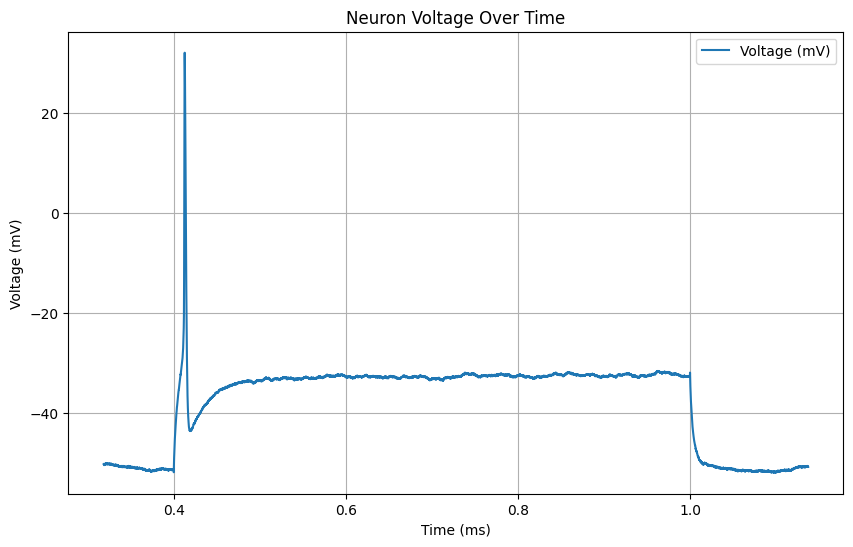

In [51]:
file_path = 'data/single_dIN.txt'  # Replace with your file path
data = pd.read_csv(file_path, delim_whitespace=True)

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['time'], data['voltage'], label='Voltage (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Neuron Voltage Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
# # load experimental data
# import scipy.stats as stats
# # df = pd.read_excel('data/single_dIN.xlsx')
# # exp_trace = df['voltage in mV']
# delta_t = 0.1 * ms

# filename = 'data/aIN_1311_f109.txt'
# columns = ['Time (s)', 'Voltage (mV)']
# df = pd.read_csv(filename,header=None,names=columns,skiprows=0,delim_whitespace=True)
# exp_trace = df['Voltage (mV)'].values.tolist()
# # exp_trace = [v*100 for v in exp_trace_int]
# exp_stats = calculate_summary_statistics(exp_trace,delta_t)


In [139]:
exp_trace = data['voltage'].values.tolist()
delta_t = 0.1 * ms

exp_stats = calculate_summary_statistics(exp_trace,delta_t)

simulator, prior = prepare_for_sbi(simulation_wrapper,prior)
inference = SNPE(prior=prior)

In [140]:
# single round SBI
theta, x = simulate_for_sbi(simulator, prior, num_simulations=100)
density_estimator = inference.append_simulations(theta,x,proposal=prior).train()
posterior = inference.build_posterior(density_estimator)
posterior_sample = posterior.sample((1,), x=exp_stats).numpy()


Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 92 epochs.

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[ 18.978416  16.847347  10.100854 144.73296  -47.347916]


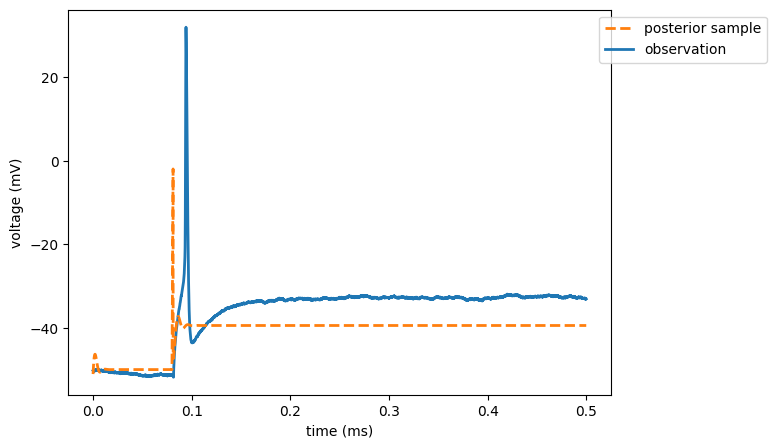

In [155]:

posterior_sample = posterior.sample((1,), x=exp_stats).numpy()
fig = plt.figure(figsize=(7, 5))
time = 0.5 * second
# plot observation
# t = observation_trace["time"]
y_obs = exp_trace
plt.plot(np.arange(0,time,delta_t), y_obs[:5000], lw=2, label="observation")

# simulate and plot samples
x, _ = run_sim(posterior_sample[0])
plt.plot(np.arange(0,time,delta_t), x[0][:5000], "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

print(posterior_sample[0])

In [156]:
posterior_sample[0]

array([ 18.978416,  16.847347,  10.100854, 144.73296 , -47.347916],
      dtype=float32)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

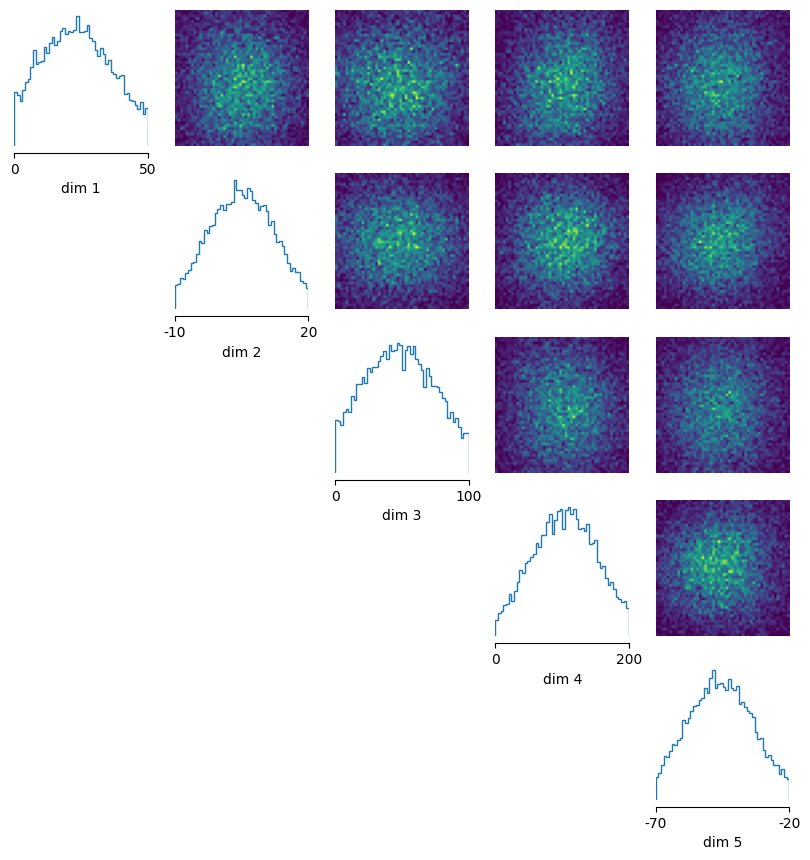

In [157]:
samples = posterior.sample((10000,), x=exp_stats)
fig, axes = analysis.pairplot(
    samples,
    limits=[[0, 50], [-10, 20], [0, 100], [0, 200], [-70, -20]],
    ticks=[[0, 50], [-10, 20], [0, 100], [0, 200], [-70, -20]],
    figsize=(10, 10),
#     points=exp_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

prior_min = [0, -10, 0, 0, -70]
prior_max = [50, 20, 100, 200, -20]

In [158]:
mode = []
for i in range(5):
    mode.append(samples[:,i].mean())
print(mode)

[tensor(23.4338), tensor(4.9859), tensor(48.2453), tensor(102.9523), tensor(-45.8445)]


In [115]:
def plot_phase_diagrams(state_monitor, neuron_indices=None):
    """
    Plots phase diagrams of v against w for specified neurons.
    
    Parameters:
    state_monitor (StateMonitor): The StateMonitor recording the neuron states.
    neuron_indices (list or array, optional): Indices of the neurons to plot. If None, plot all neurons.
    """
    if neuron_indices is None:
        neuron_indices = range(len(state_monitor.v))

    for idx in neuron_indices:
        plt.figure()
        plt.plot(state_monitor.v[idx]/mV, state_monitor.w[idx]/pA, label=f'Neuron {idx}')
        plt.xlabel('Membrane potential (mV)')
        plt.ylabel('Adaptation variable w (pA)')
        plt.title(f'Phase Diagram for Neuron {idx}')
        plt.legend()
        plt.show()

In [160]:
# let's try with aIN first since dIN params are a bit uncertain
def test_sim(sbi_params):
    
    start_scope()
    
    N_D = 1
    
    # sbi params
     # try fixing cm = 4pF, resting potential/E_L = -51mV, Ap threshold -28mV, g_l = 3.68 from Sauotis et al., 2007 
    din_cm = 4 * pF
    din_g_L = 3.68 * nS 
    din_E_L = -51 * mV 
    din_V_T = -28 * mV 
    din_slope_f = float(sbi_params[0]) * mV 
    din_a = float(sbi_params[1]) * nS 
    din_tau_w = float(sbi_params[2]) * ms 
    din_b = float(sbi_params[3]) * pA 
    din_V_reset = float(sbi_params[4]) * mV
    din_i_stim = 70
    min_i = 0

#     # naud et al params
#     din_cm = 100 * pF 
#     din_g_L = 10 * nS 
#     din_E_L = -65 * mV 
#     din_V_T = -50 * mV 
#     din_slope_f = 2 * mV 
#     din_a = -10 * nS 
#     din_tau_w = 90 * ms 
#     din_b = 30 * pA 
#     din_V_reset = -47 * mV
#     din_i_stim = 350
#     min_i = 10
    
    # Define the time points and corresponding values
    #values = [0, din_i_stim, 0, din_i_stim, 0] * pA
    values = [min_i, din_i_stim, min_i, min_i, din_i_stim] * pA

    # Create the TimedArray
    timed_array = TimedArray(values, dt=0.2*second)

    E_ex = 0 * mV
    E_in = -70 * mV

    v_spike_threshold = 0 * mV
    simulation_time = 1*second

    parameters = {'general': {'tau_exc':5*ms, 'tau_inh':5*ms, 'v_sp':v_spike_threshold},
                'dins': {'N': N_D, 'b':din_b, 'a':din_a, 'tau_w':din_tau_w, 'slope_f':din_slope_f, 'vr':din_V_reset, 'c_m':din_cm, 'e_l':din_E_L, \
                        'v_t': din_V_T, 'g_l': din_g_L, 'v_initial':din_E_L, 'i_stim':timed_array} \
                }



    eqs = """
    dv/dt = (-g_l*(v-e_l) + g_l*slope_f*exp((v-v_t)/slope_f) + i_stim(t) - w)/c_m : volt
    dw/dt = (a*(v - e_l) - w)/tau_w : amp
    """

    din_params = parameters['general'].copy()
    din_params.update(parameters['dins'])

    # Define neuron groups
    din = NeuronGroup(N_D, model=eqs, method='euler', threshold='v > 0*mV', reset='v = vr\nw = w + b', namespace=din_params)

    din.v = parameters['dins']['e_l']

    din.w = 0

    mon_din = StateMonitor(din, ['v', 'w'], record=0)  # Record the membrane potential of the first dIN
    din_spike_mon = SpikeMonitor(din)
    defaultclock.dt = 0.1 * ms
    time_secs = simulation_time
    run(time_secs)

#     fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 16), sharex=True)
#     ax[0].plot(mon_din.t / ms, mon_din.v[0]/mV, label='din voltage', color='blue')
#     ax[0].set(ylabel='Voltage (mV)')
#     ax[1].plot(mon_din.t / ms, mon_din.g_exc[0]/nsiemens, label='din g exc', color='blue')
#     ax[1].set(ylabel='g exc (nsiemens)')
#     ax[2].plot(mon_din.t / ms, mon_din.g_inh[0]/mV, label='din g inh', color='blue')
#     ax[2].set(ylabel='g inh (nsiemens)')
#     ax[3].plot(mon_din.t / ms, mon_din.w[0]/pA, label='din w', color='blue')
#     ax[3].set(xlabel='Time (ms)', ylabel='w (nA)')


#     ax[0].legend()
#     ax[1].legend()
#     ax[2].legend()
#     ax[3].legend()

    plot_phase_diagrams(mon_din)
    
    return mon_din.v / mV, din_spike_mon.t / ms

<Figure size 700x500 with 0 Axes>

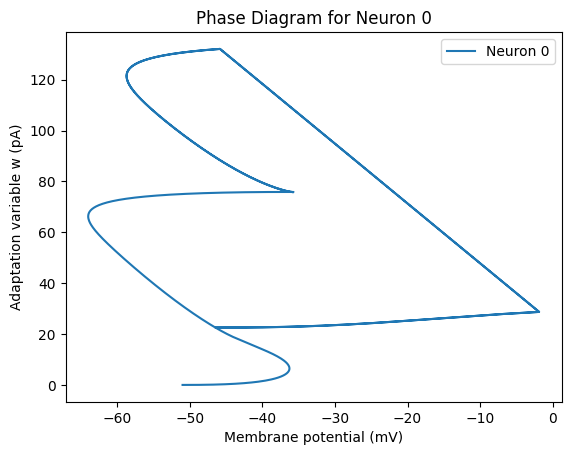

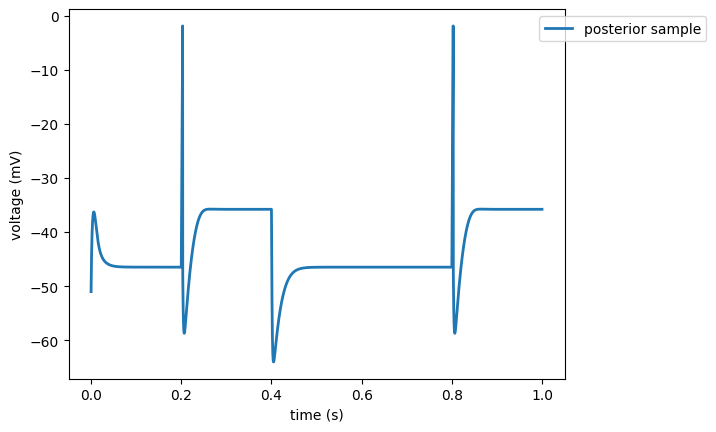

In [161]:
#122.63597
#params = [6.483391, 2.8503335, 15.394455, 19.922102, -24.338558, 90]
#params = [19.57105, 13.944486, 52.57742, 108.38179, -33.227917]
params = [23.4338, 4.9859, 48.2453, 102.9523, -45.8445]
# params = [17.585796, 10.0460005, 60.212124, 143.60281, -54.102287]
# params = [21.3193, 7.5095, 52.1369, 97.2908, -45.9228]
#params = [tensor.item() for tensor in mode]
fig = plt.figure(figsize=(7, 5))
delta_t = 0.0001
time = 1
# plot observation
# t = observation_trace["time"]
# y_obs = exp_trace[:5000]
# plt.plot(np.arange(0,time,delta_t)[:5000], y_obs, lw=2, label="observation")

# simulate and plot samples
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
x, _ = test_sim(params)
plt.plot(np.arange(0,time,delta_t)[:10000], x[0][:10000], lw=2, label="posterior sample")

plt.xlabel("time (s)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

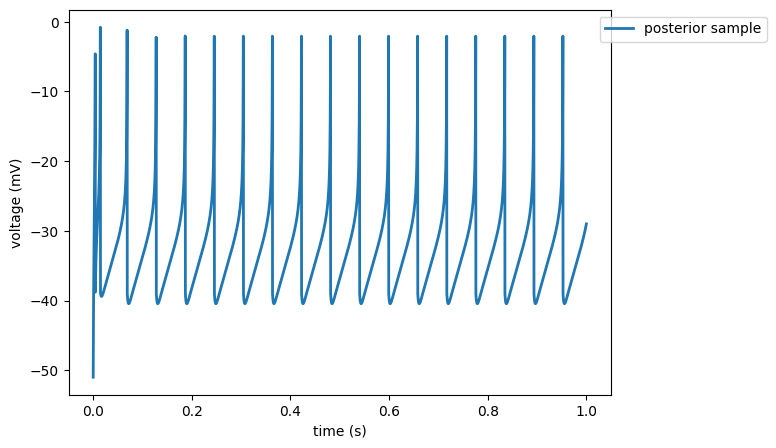

In [106]:
#cin params

params = [12.8, 0.62, 58.6, 21.6, -38.8]
fig = plt.figure(figsize=(7, 5))
delta_t = 0.0001
time = 1

x, _ = test_sim(params)
plt.plot(np.arange(0,time,delta_t)[:10000], x[0][:10000], lw=2, label="posterior sample")

plt.xlabel("time (s)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

In [95]:
def test_xin(sbi_params):
        
    start_scope()
    
    N_D = 1
    
    # sbi params
     # try fixing cm = 4pF, resting potential/E_L = -51mV, Ap threshold -28mV, g_l = 3.68 from Sauotis et al., 2007 
#     din_cm = 4 * pF
#     din_g_L = 3.68 * nS 
#     din_E_L = -51 * mV 
#     din_V_T = -28 * mV 
    din_cm = 100 * pF
    din_g_L = 10 * nS 
    din_E_L = -65 * mV 
    din_V_T = -50 * mV 
    din_slope_f = float(sbi_params[0]) * mV 
    din_a = float(sbi_params[1]) * nS 
    din_tau_w = float(sbi_params[2]) * ms 
    din_b = float(sbi_params[3]) * pA 
    din_V_reset = float(sbi_params[4]) * mV

    E_ex = 0 * mV
    E_in = -70 * mV

    v_spike_threshold = 0 * mV
    simulation_time = 5*second

    parameters = {'general': {'tau_exc':5*ms, 'tau_inh':5*ms, 'E_exc':E_ex, 'E_inh':E_in, 'v_sp':v_spike_threshold},
                'dins': {'N': N_D, 'b':din_b, 'a':din_a, 'tau_w':din_tau_w, 'slope_f':din_slope_f, 'vr':din_V_reset, 'c_m':din_cm, 'e_l':din_E_L, \
                        'v_t': din_V_T, 'g_l': din_g_L, 'v_initial':din_E_L} \
                }



    eqs = """
    dv/dt = (g_l*(e_l-v) + g_l*slope_f*exp((v-v_t)/slope_f) - g_exc*(v-E_exc) - g_inh*(v-E_inh) - w)/c_m : volt
    dw/dt = (a*(v - e_l) - w)/tau_w : amp
    dg_exc/dt = -g_exc/tau_exc : siemens 
    dg_inh/dt = -g_inh/tau_inh : siemens
    """

    din_params = parameters['general'].copy()
    din_params.update(parameters['dins'])

    # Define neuron groups
    din = NeuronGroup(N_D, model=eqs, method='euler', threshold='v > 0*mV', reset='v = vr\nw = w + b', namespace=din_params)

    din.v = parameters['dins']['e_l']

    din.w = 0
    
    synaptic_model = '''
          w_syn : siemens
          d : 1
          '''

    external_input_rate = 16*Hz
    external_input_weight_ampa = 1.4*nsiemens
    external_input_weight_nmda = 0.7*nsiemens

    xin_l = PoissonGroup(1, rates=external_input_rate)

    S_xin_din_ampa = Synapses(xin_l, din, model=synaptic_model, on_pre='g_exc += w_syn')
    S_xin_din_ampa.connect()
    S_xin_din_ampa.w_syn = 100*nsiemens

    mon_din = StateMonitor(din, ['v', 'g_exc', 'g_inh', 'w'], record=0)  # Record the membrane potential of the first dIN
    din_spike_mon = SpikeMonitor(din)
    defaultclock.dt = 0.1 * ms
    time_secs = simulation_time
    run(time_secs)

#     fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 16), sharex=True)
#     ax[0].plot(mon_din.t / ms, mon_din.v[0]/mV, label='din voltage', color='blue')
#     ax[0].set(ylabel='Voltage (mV)')
#     ax[1].plot(mon_din.t / ms, mon_din.g_exc[0]/nsiemens, label='din g exc', color='blue')
#     ax[1].set(ylabel='g exc (nsiemens)')
#     ax[2].plot(mon_din.t / ms, mon_din.g_inh[0]/mV, label='din g inh', color='blue')
#     ax[2].set(ylabel='g inh (nsiemens)')
#     ax[3].plot(mon_din.t / ms, mon_din.w[0]/pA, label='din w', color='blue')
#     ax[3].set(xlabel='Time (ms)', ylabel='w (nA)')


#     ax[0].legend()
#     ax[1].legend()
#     ax[2].legend()
#     ax[3].legend()
    
    return mon_din.v / mV, din_spike_mon.t / ms


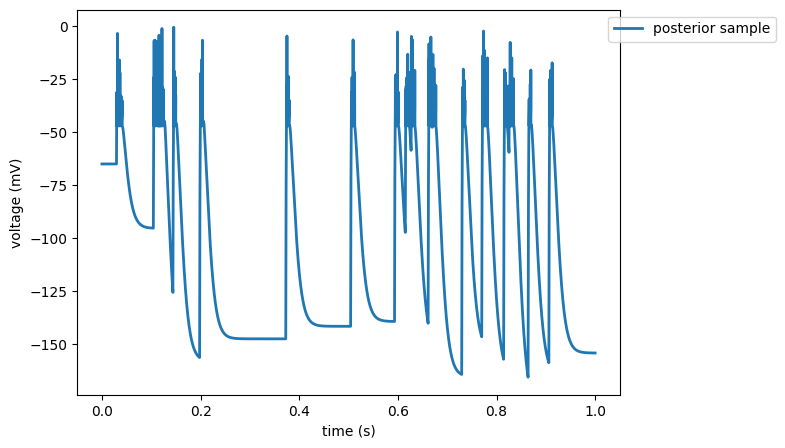

In [96]:
#122.63597
#params = [6.483391, 2.8503335, 15.394455, 19.922102, -24.338558, 90]
params = [19.57105, 13.944486, 52.57742, 108.38179, -33.227917]
params = [2, -10, 90, 30, -47]
# params = [17.585796, 10.0460005, 60.212124, 143.60281, -54.102287]
# params = [21.3193, 7.5095, 52.1369, 97.2908, -45.9228]
#params = [tensor.item() for tensor in mode]
fig = plt.figure(figsize=(7, 5))
delta_t = 0.0001
time = 1
# plot observation
# t = observation_trace["time"]
# y_obs = exp_trace[:5000]
# plt.plot(np.arange(0,time,delta_t)[:5000], y_obs, lw=2, label="observation")

# simulate and plot samples
# sum_stats = calculate_summary_statistics(x,delta_t,V_thr,t_on)
# cost = calc_costs(sum_stats,exp_stats)
x, _ = test_xin(params)
plt.plot(np.arange(0,time,delta_t)[:10000], x[0][:10000], lw=2, label="posterior sample")

plt.xlabel("time (s)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

In [116]:
import scipy.stats as stats
# dins = params = [6.483391, 2.8503335, 15.394455, 19.922102, -24.338558, 90]
params = [12.8, 0.62, 58.6, 21.6, -38.8, 50]
obs_v, obs_spikes = run_sim(params)
summstats = torch.from_numpy(calculate_summary_statistics(obs_v[0],delta_t))
print(summstats[0].item())

20.0


In [117]:
exp_stats = list(exp_stats)
summstats = [summstats[i].item() for i in range(len(summstats))]
summstats

[20.0,
 0.1047,
 0.00860000000000001,
 0.048900000000000055,
 -54.0,
 -38.172723994978284,
 10.094949244696041,
 0.8341637026080302,
 0.5145670791461554]

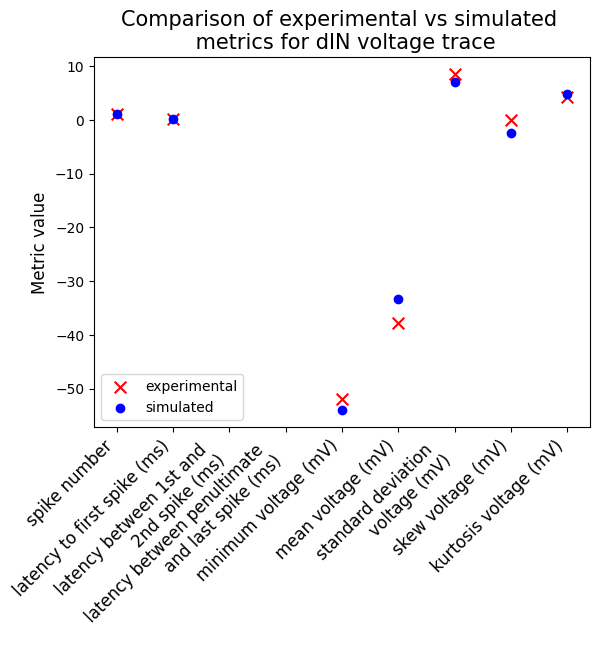

In [111]:
# dIN
import numpy as np
stats = ['spike number', 'latency to first spike (ms)', 'latency between 1st and \n 2nd spike (ms)', \
         ' latency between penultimate \n and last spike (ms)', 'minimum voltage (mV)', 'mean voltage (mV)', \
         'standard deviation \n voltage (mV)', 'skew voltage (mV)', 'kurtosis voltage (mV)']
plt.scatter([0,1,4,5,6,7,8], exp_stats[:2]+exp_stats[-5:], color='r', marker='x', s=70, label='experimental')
plt.scatter([0,1,4,5,6,7,8], summstats[:2]+summstats[-5:], color='b', label='simulated')
plt.ylabel('Metric value',fontsize=12)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], stats, rotation=45, ha='right', fontsize=12)
plt.title('Comparison of experimental vs simulated \n metrics for dIN voltage trace', fontsize=15)
plt.legend(loc='lower left')

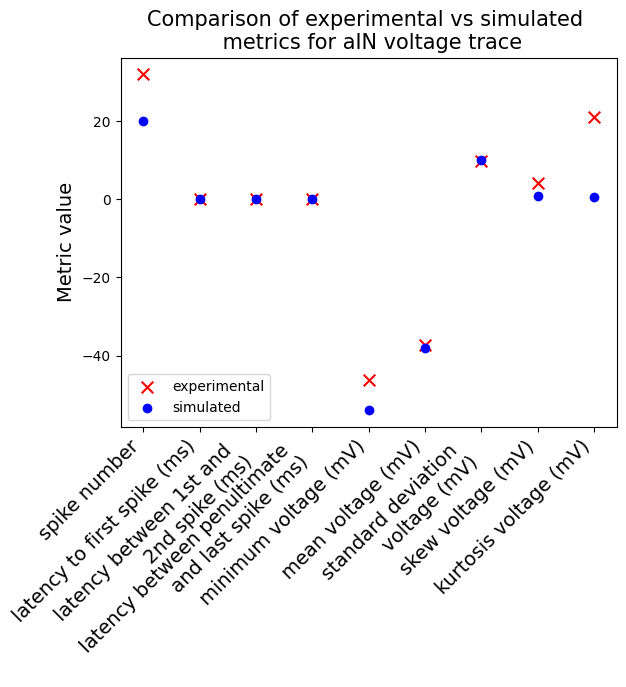

In [121]:
import numpy as np
stats = ['spike number', 'latency to first spike (ms)', 'latency between 1st and \n 2nd spike (ms)', \
         ' latency between penultimate \n and last spike (ms)', 'minimum voltage (mV)', 'mean voltage (mV)', \
         'standard deviation \n voltage (mV)', 'skew voltage (mV)', 'kurtosis voltage (mV)']
plt.scatter(range(len(exp_stats)), exp_stats, color='r', marker='x', s=70, label='experimental')
plt.scatter(range(len(exp_stats)), summstats, color='b', label='simulated')
plt.ylabel('Metric value', fontsize=14)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], stats, rotation=45, ha='right', fontsize=14)
plt.title('Comparison of experimental vs simulated \n metrics for aIN voltage trace', fontsize=15)
plt.legend(loc='lower left')

In [32]:
exp_stats

array([ 1.00000000e+00,  9.37000000e-02,  1.00000000e+05,  1.00000000e+05,
       -5.18554690e+01, -3.77250006e+01,  8.51040963e+00, -4.29513514e-02,
        4.24995463e+00])

In [33]:
summstats

tensor([ 3.0000e+00,  1.0200e-01,  1.0000e-03,  1.6000e-03, -5.1000e+01,
        -3.1359e+01,  6.5816e+00, -2.5308e+00,  4.9670e+00],
       dtype=torch.float64)

[ 11.438891    2.9286225  20.09254    57.518383  -32.26446    99.79603  ]


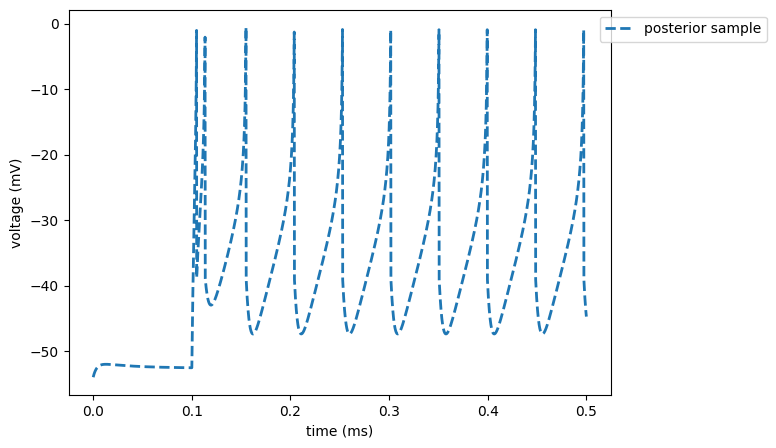

In [65]:

fig = plt.figure(figsize=(7, 5))
time = 0.5 * second


# simulate and plot samples
x, _ = run_sim([12.8, 0.62, 58.6, 21.6, -38.8, 50])
plt.plot(np.arange(0,time,delta_t), x[0][:5000], "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

print(posterior_sample[0])